<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Distributions/Broadcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Broadcasting rules

This reading will introduce you to numpy's broadcasting rules and show how you can use broadcasting when specifying batches of distributions in TensorFlow, as well as with the `prob` and `log_prob` methods.

Broadcasting will also be discussed and demonstrated in the following videos.

## Operations on arrays of different sizes in numpy

Numpy operations can be applied to arrays that are not of the same shape, but only if the shapes satisfy certain conditions.

As a demonstration of this, let us add together two arrays of different shapes:

This is the addition

    [ [1.],    +  [0., 1., 2.]  
      [2.],  
      [3.],  
      [4.] ]

To execute it, numpy:
1. Aligned the shapes of `a` and `b` on the last axis and prepended 1s to the shape with fewer axes:
        a: 4 x 1     --->    a: 4 x 1
        b:     3     --->    b: 1 x 3
        

2. Checked that the sizes of the axes matched or were equal to 1:
        a: 4 x 1  
        b: 1 x 3
`a` and `b` satisfied this criterion.


3. Stretched both arrays on their 1-valued axes so that their shapes matched, then added them together.  
`a` was replicated 3 times in the second axis, while `b` was replicated 4 times in the first axis.

This meant that the addition in the final step was

    [ [1., 1., 1.],    +  [ [0., 1., 2.],  
      [2., 2., 2.],         [0., 1., 2.],  
      [3., 3., 3.],         [0., 1., 2.],  
      [4., 4., 4.] ]        [0., 1., 2.] ]
      
Addition was then carried out element-by-element, as you can verify by referring back to the output of the code cell above.  
This resulted in an output with shape 4 x 3.


## Numpy's broadcasting rule

Broadcasting rules describe how values should be transmitted when the inputs to an operation do not match.  
In numpy, the broadcasting rule is very simple:
> Prepend 1s to the smaller shape,   
check that the axes of both arrays have sizes that are equal or 1,  
then stretch the arrays in their size-1 axes.

A crucial aspect of this rule is that it does not require the input arrays have the same number of axes.  
Another consequence of it is that a broadcasting output will have the largest size of its inputs in each axis.  
Take the following multiplication as an example:

        a: 3 x 7 x 1  
        b:     1 x 5  
    a * b: 3 x 7 x 5

You can see that the output shape is the maximum of the sizes in each axis.

Numpy's broadcasting rule also does not require that one of the arrays has to be bigger in all axes.  
This is seen in the following example, where `a` is smaller than `b` in its third axis but is bigger in its second axis.

Broadcasting behaviour also points to an efficient way to compute an outer product in numpy

The idea of numpy stretching the arrays in their size-1 axes is useful and is functionally correct. But this is not what numpy literally does behind the scenes, since that would be an inefficient use of memory. Instead, numpy carries out the operation by looping over singleton (size-1) dimensions.

To give you some practise with broadcasting, try predicting the output shapes for the following operations:

In [ ]:
import numpy as np

# Define three arrays with different shapes
a = np.array([[1], [2], [3]])
print("a shape:", a.shape)
b = np.zeros(shape=(10, 1, 1))
print("b shape:", b.shape)
c = np.ones(shape=(4, 1))
print("c shape:", c.shape)

# Predict the shape before executing this cell
# Add two arrays with different shapes
print("a + b shape:", (a + b).shape)
# Use broadcasting to compute and outer product ac^T,
# where a and c are column vectors
print("ac^T shape:", (a*c.T).shape)
print("a*b + c^T shape:", (a*b + c.T).shape)

a shape: (3, 1)
b shape: (10, 1, 1)
c shape: (4, 1)
a + b shape: (10, 3, 1)
ac^T shape: (3, 4)
a*b + c^T shape: (10, 3, 4)


## Broadcasting for univariate TensorFlow Distributions

The broadcasting rule for TensorFlow is the same as that for numpy. For example, TensorFlow also allows you to specify the parameters of Distribution objects using broadcasting.

What is meant by this can be understood through an example with the univariate normal distribution. Say that we wish to specify a parameter grid for six Gaussians. The parameter combinations to be used, `(loc, scale)`, are:  

    (0, 1)  
    (0, 10)  
    (0, 100)  
    (1, 1)  
    (1, 10)  
    (1, 100)
    
A laborious way of doing this is to explicitly pass each parameter to `tfd.Normal`.

A more succinct way to create a batch of distributions for this parameter grid is to use broadcasting.  
Consider what would happen if we were to broadcast these arrays according the rule discussed earlier:
    
    loc = [ [0.],
            [1.] ]
    scale = [1., 10., 100.]
    
The shapes would be stretched according to

    loc:   2 x 1 ---> 2 x 3
    scale: 1 x 3 ---> 2 x 3
    
resulting in

    loc = [ [0., 0., 0.],
            [1., 1., 1.] ]
    scale = [ [1., 10., 100.],
              [1., 10., 100.] ]
              
which are compatible with the `loc` and `scale` arguments of `tfd.Normal`.  
Sure enough, this is precisely what TensorFlow does:

Distribution: tfp.distributions.Normal("Normal", batch_shape=[2, 3], event_shape=[], dtype=float32)
Loc: [0. 5.]
Scale: [1. 2. 3.]
Samples shape: (10000, 2, 3)
pdf shape: (10000, 2, 3)


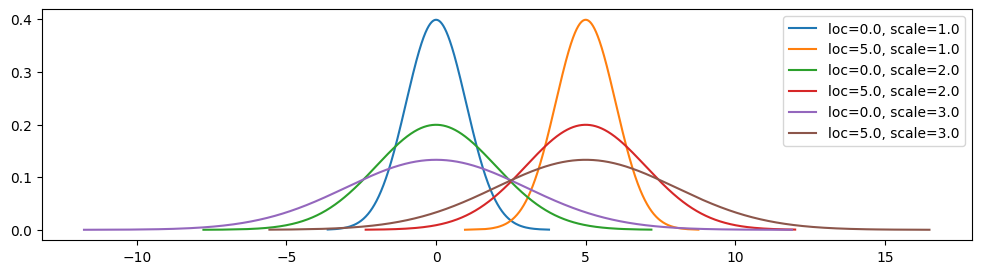

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

# Define a batch of Normal distributions with broadcasting
locs = tf.constant(value=[[0.], [5.]], dtype=tf.float32)
scales = tf.constant(value=[1., 2., 3.], dtype=tf.float32)
normal = tfp.distributions.Normal(loc=locs, scale=scales)
# Print the distribution and notice the batch and event shapes
print("Distribution:", normal)
# The stored loc parameter values are what you pass in,
# not what is used after broadcasting
locs = normal.loc.numpy().squeeze()
print("Loc:", locs)
# The stored scale parameter values are what you pass in,
# not what is used after broadcasting
scales = normal.scale.numpy()
print("Scale:", scales)

samples = normal.sample(sample_shape=10000)
print("Samples shape:", samples.shape)
pdf = normal.prob(value=samples)
print("pdf shape:", pdf.shape)
plt.figure(figsize=(12, 3))
for i, s in enumerate(scales):
    g = sns.lineplot(x=samples[:, 0, i], y=pdf[:, 0, i],
        label=f"loc={locs[0]}, scale={scales[i]}")
    g = sns.lineplot(x=samples[:, 1, i], y=pdf[:, 1, i],
        label=f"loc={locs[1]}, scale={scales[i]}")
plt.show()

In summary, TensorFlow broadcasts parameter arrays: it stretches them according to the broadcasting rule, then creates a distribution on an element-by-element basis.

#### Broadcasting with `prob` and `log_prob` methods

When using `prob` and  `log_prob` with broadcasting, we follow the same principles as before. Let's make a new batch of normals as before but with means which are centered at different locations to help distinguish the results we get.

We can feed in samples of any shape as long as it can be broadcast agasint our batch shape for this example.

`log_prob` works in the exact same way with broadcasting. We can replace `prob` with `log_prob` in any of the previous examples:

## Broadcasting for multivariate TensorFlow distributions

Broadcasting behaviour for multivariate distributions is only a little more sophisticated than it is for univariate distributions.

Recall that `MultivariateNormalDiag` has two parameter arguments: `loc` and `scale_diag`. When specifying a single distribution, these arguments are vectors of the same length:

The size of the final axis of the inputs determines the event shape for each distribution in the batch.  This means that if we pass
    
    loc = [ [0., 0.],
            [1., 1.] ]
    scale_diag = [1., 0.5]
    
such that

    loc:        2 x 2
    scale_diag: 1 x 2
                    ^ final dimension is interpreted as event dimension
                ^ other dimensions are interpreted as batch dimensions  
then a batch of two bivariate normal distributions will be created.

Knowing that, for multivariate distributions, TensorFlow

- interprets the final axis of an array of parameters as the event shape,


- and broadcasts over the remaining axes,  

can you predict what the batch and event shapes will if we pass the arguments


    loc = [ [ 1.],
            [-1.] ] # shape (2, 1)
    scale_diag = [ [[0.1, 0.2, 0.3]],
                   [[1., 2., 3.]] ] # shape (2, 1, 3)
                   
to `MultivariateNormalDiag`?

Solution:

Align the parameter array shapes on their last axis, prepending 1s where necessary:  
    
           loc: 1 x 2 x 1  
    scale_diag: 2 x 1 x 3  

The final axis has size 3, so `event_shape = (3)`. The remaining axes are broadcast over to yield  
    
           loc: 2 x 2 x 3  
    scale_diag: 2 x 2 x 3  

so `batch_shape = (2, 2)`.

Let's see if this is correct!

Distribution: tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[2], event_shape=[2], dtype=float32)
Parameters: {'loc': <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [1.]], dtype=float32)>, 'scale_diag': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 2.], dtype=float32)>, 'validate_args': False, 'allow_nan_stats': True, 'experimental_use_kahan_sum': False, 'name': 'MultivariateNormalDiag'}
Loc: tf.Tensor(
[[0.]
 [1.]], shape=(2, 1), dtype=float32)
Covariance: tf.Tensor(
[[[1. 0.]
  [0. 4.]]

 [[1. 0.]
  [0. 4.]]], shape=(2, 2, 2), dtype=float32)
Samples shape: (10000, 2, 2)


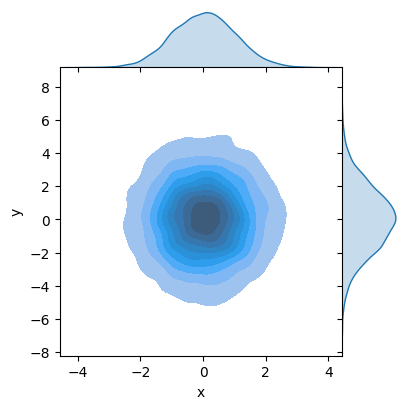

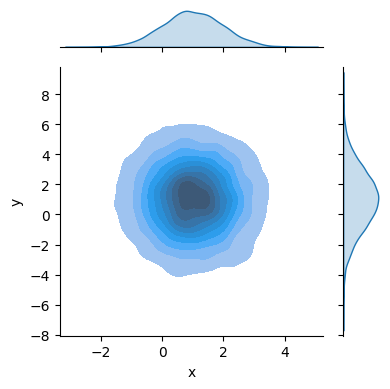

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

# Define a multivariate Gaussian distribution with broadcasting
loc = tf.constant(value=[[0.], [1.]], dtype=tf.float32)
scale_diag = tf.constant(value=[1., 2.], dtype=tf.float32)

mv_normal = tfp.distributions.MultivariateNormalDiag(
    loc=loc, scale_diag=scale_diag)
# Print the distribution - note the event shape and batch shape
print("Distribution:", mv_normal)
# Print the distribution parameters
# There is a batch of two distributions
# with different means and same covariance
print("Parameters:", mv_normal.parameters)
# Print the loc parameter
print("Loc:", mv_normal.loc)
# Print the covariance matrix - the diagonal is scale_diag^2
print("Covariance:", mv_normal.covariance())

samples = mv_normal.sample(sample_shape=10000)
print("Samples shape:", samples.shape)

for i in [0, 1]:
    x, y = samples[:, i, 0], samples[:, i, 1]
    g = sns.jointplot(x=x, y=y, kind="kde",
        space=0, fill=True, height=4)
    g.set_axis_labels(xlabel="x", ylabel="y")
plt.tight_layout()
plt.show()

As we did before lets also look at broadcasting when we have batches of multivariate distributions.

And to refresh our memory of `Independent` we'll use it below to roll the rightmost batch shape into the event shape.

Now, onto the broadcasting:

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define a batch of Normal distributions with broadcasting
loc = tf.constant(value=[[0], [1]], dtype=tf.float32)
scale = tf.constant(value=[1, 10, 100], dtype=tf.float32)

normal = tfp.distributions.Normal(loc=loc, scale=scale)
print("Univariate normal:", normal)
# Create a multivariate Independent distribution
ind_normal = tfp.distributions.Independent(distribution=normal,
    reinterpreted_batch_ndims=1)
print("Multivariate independent normal:", ind_normal)

# Use broadcasting with the prob method
# B shaped input (broadcast over event)
sample = tf.random.uniform(shape=(2, 1))
prob = ind_normal.prob(value=sample)
print(f"Sample shape {sample.shape}, Prob shape {prob.shape}")

# E shaped input (broadcast over batch)
sample = tf.random.uniform(shape=(1, 3))
prob = ind_normal.prob(value=sample)
print(f"Sample shape {sample.shape}, Prob shape {prob.shape}")

# [S,b,e] shaped input where [b,e] can be broadcast agaisnt [B,E]
sample = tf.random.uniform(shape=(5, 1, 1))
prob = ind_normal.prob(value=sample)
print(f"Sample shape {sample.shape}, Prob shape {prob.shape}")

Univariate normal: tfp.distributions.Normal("Normal", batch_shape=[2, 3], event_shape=[], dtype=float32)
Multivariate independent normal: tfp.distributions.Independent("IndependentNormal", batch_shape=[2], event_shape=[3], dtype=float32)
Sample shape (2, 1), Prob shape (2,)
Sample shape (1, 3), Prob shape (2,)
Sample shape (5, 1, 1), Prob shape (5, 2)


You should now feel confident specifying batches of distributions using broadcasting. As you may have already guessed, broadcasting is especially useful when specifying grids of hyperparameters.

If you don't feel entirely comfortable with broadcasting quite yet, don't worry: re-read this notebook, go through the further reading provided below, and experiment with broadcasting in both numpy and TensorFlow, and you'll be broadcasting in no time.

### Further reading and resources
* Numpy documentation on broadcasting: https://numpy.org/devdocs/user/theory.broadcasting.html
* https://www.tensorflow.org/xla/broadcasting